# Darknet Object Detection using Tiny Yolov3

create folders

In [1]:
!mkdir -p ./data/images

copy images

In [2]:
!cp ../pytorch/dataset/images/field/*/* ./data/images/

Bounding Boxes are creates using codel like below, its tricky and does not work in all cases properly

(600, 800, 3)
298 276 498 325


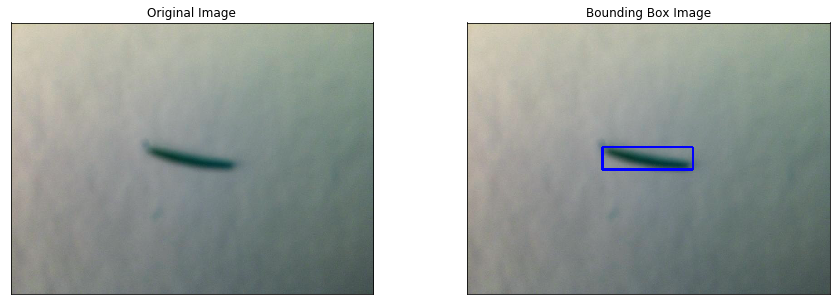

In [142]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


def bounding_box(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray= cv2.GaussianBlur(gray, (7,7),0)
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,17,2)
    edges = cv2.Canny(thresh,50,150)

    kernel = np.ones((5,5), dtype=np.uint8)
    closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    _,contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cnt = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(cnt)
    return(x,y,w,h)

img = cv2.imread('data/images/13002223733528.jpg')
out=img.copy()
(x,y,w,h) = bounding_box(img)
if x == 0 or y == 0:
    imgcropped = img[50:img.shape[0]-50, 50:img.shape[1]]
    (x,y,w,h) = bounding_box(imgcropped)
    x+=50
    y+=50

print(img.shape)
x2=x+w
y2=y+h
print(x,y,x2,y2)
cv2.rectangle(out, (x,y), (x2, y2), (0,0,255), 4)

plt.figure(figsize=(15, 5))
plt.subplot(121),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(out)
plt.title('Bounding Box Image'), plt.xticks([]), plt.yticks([])

plt.show()

Create bounding box GT file

In [134]:
!python create_boundingboxes.py

clone the darknet tool for tiny yolov3

In [135]:
!git clone https://github.com/AlexeyAB/darknet.git

Klone nach 'darknet' ...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 12624 (delta 0), reused 1 (delta 0), pack-reused 12617
Empfange Objekte: 100% (12624/12624), 11.69 MiB | 7.56 MiB/s, Fertig.
Löse Unterschiede auf: 100% (8567/8567), Fertig.


Before the build set the GPU flag and the CUDNN flag in the Makefile if you have one.

In [ ]:
!make

create the leaf dataset config

In [136]:
!mkdir -p darknet/data/leaf;cp names.txt ./darknet/data/leaf/;cp leaf.data ./darknet/cfg/
!cp yolov3-tiny-leaf-*.cfg ./darknet/cfg/

create train and val file list (90% train / 10%val) randomly shuffeld in the data folder

In [137]:
import random
import glob
import os

path='./data/images/*.jpg'
names=[]
filelist = sorted(glob.glob(path))
for file in filelist:
    names.append(os.getcwd()+file[1:]+'\n')

random.shuffle(names)

trainlinesCount = int(len(names)*0.9)
vallinesCount = len(names) - trainlinesCount

print("names:{} train:{} val:{}".format(len(names),trainlinesCount,vallinesCount))

with open("./darknet/data/leaf/train.txt", "w") as f:
    f.writelines(names[:trainlinesCount])
with open("./darknet/data/leaf/valid.txt", "w") as f:
    f.writelines(names[trainlinesCount:])
    

names:7719 train:6947 val:772


### Train the tiny yolov3 darknet model

start the training (10000 steps). Add -show_imgs to see detected bounding boxes

In [ ]:
cd darknet;./darknet detector train cfg/leaf.data cfg/yolov3-tiny-leaf-train.cfg -map

start the validation

In [ ]:
cd darknet;./darknet detector valid cfg/leaf.data cfg/yolov3-tiny-leaf-test.cfg backup/yolov3-tiny-leaf-train_best.weights

### Convert the tiny yolov3 darknet model to tensor flow

clone the tensorflow converter for tiny yolov3

In [143]:
!git clone https://github.com/mystic123/tensorflow-yolo-v3

Klone nach 'tensorflow-yolo-v3' ...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 219 (delta 1), reused 2 (delta 0), pack-reused 213
Empfange Objekte: 100% (219/219), 59.90 KiB | 638.00 KiB/s, Fertig.
Löse Unterschiede auf: 100% (111/111), Fertig.


convert the darknet model to a tensorflow model

In [ ]:
!mkdir ./pbmodel;cd ./tensorflow-yolo-v3;python ./convert_weights_pb.py --class_names ../names.txt  --weights_file ../darknet/backup/yolov3-tiny-leaf-train_best.weights --tiny --output_graph  ../pbmodel/yolov3-tiny-leaf-train_best.graph --data_format NHWC

run the demo program on the tensorflow model

In [146]:
!cd ./tensorflow-yolo-v3;python demo.py --input_img ../data/images/13002223733528.jpg --frozen_model ../pbmodel/yolov3-tiny-leaf-train_best.graph --class_names ../names.txt --gpu_memory_fraction 0.1 --output_img ./test.jpg --conf_threshold 0.1 --iou_threshold .3

/home/frank/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/frank/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/frank/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/frank/anaconda3/envs/py36/lib/python3.6/site-pack

2020-03-11 10:52:46.168794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1181] Device interconnect StreamExecutor with strength 1 edge matrix:
2020-03-11 10:52:46.168824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1187]      0 
2020-03-11 10:52:46.168833: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1200] 0:   N 
2020-03-11 10:52:46.168998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-03-11 10:52:46.169393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-03-11 10:52:46.169714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
20

Text(0.5, 1.0, 'bounding box')

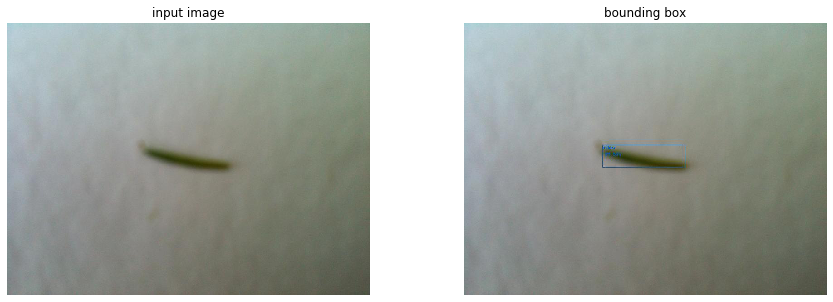

In [148]:
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

image = Image.open('./data/images/13002223733528.jpg')
bb_image = Image.open('tensorflow-yolo-v3/test.jpg')


plt.figure(figsize=(15, 5))
grid_spec = gridspec.GridSpec(1, 2, width_ratios=[6, 6])

plt.subplot(grid_spec[0])
plt.imshow(image)
plt.axis('off')
plt.title('input image')

plt.subplot(grid_spec[1])
plt.imshow(bb_image)
plt.axis('off')
plt.title('bounding box')



In [18]:
### Convert the tiny yolov3 tensorflow to openvino

convert the model to IR openvino. It is copied to the DC-Box/openvion folder

In [ ]:
!./openvinoConvertScript.sh

In [150]:
!cp ./yolov3-tiny-leaf-train_best.xml ../openvino/model_leaf_detection_01.xml;cp ./yolov3-tiny-leaf-train_best.bin ../openvino/model_leaf_detection_01.bin